# 압력 왜곡 최소화 Heatmap 생성 Notebook

### `pressure_heatmap_pipeline.ipynb` 코드 흐름 정리

이 노트북은 Jet 컬러맵으로 색칠된 Footprint 이미지지를 입력으로 받아,
이를 **0~255 압력 값으로 복원**하고, 시각화하기 좋게 가공한 뒤
**Raw / Equalized 두 가지 heatmap**으로 보여주는 파이프라인입니다.

---

#### 1. Jet 컬러 → 압력 값(LUT 기반 역변환)

- `get_jet_lut()`
  - matplotlib의 `'jet'` 컬러맵에서 **0~255 단계의 색상 LUT**(RGB 테이블)를 만듭니다.
- `jet_to_intensity(rgb)`
  - 입력 RGB 이미지의 각 픽셀 색을 LUT와 비교해서  
    **가장 가까운 색의 인덱스(0~255)**를 찾고, 이를 **압력 intensity 값**으로 사용합니다.
  - 결과: Jet 컬러 이미지 → **단일 채널(0~255) 압력 맵**

---

#### 2. 배경 제거 및 압력 맵 생성

- `get_background_mask(rgb, thr=10)`
  - 이미지를 Grayscale로 바꾼 뒤, **밝기 `thr` 이하인 어두운 영역을 배경**으로 간주합니다.
  - 배경 위치(True/False)를 나타내는 **마스크**를 반환합니다.
- `make_pressure_map(img)`
  - Jet 컬러 이미지를 `jet_to_intensity`로 압력 맵으로 만든 후,
  - `get_background_mask`로 얻은 배경 위치의 값은 **0으로 만들어**  
    **발바닥 부분만 남긴 압력 맵**을 만듭니다.

---

#### 3. 시각화용 히스토그램 평활화

- `equalize_for_visualization(pmap)`
  - OpenCV의 `equalizeHist`를 이용해 **압력이 있는 부분만** 대비를 키워 줍니다.
  - 배경(값 0)은 따로 처리하여 **평활화 과정에서 배경이 밝아지지 않도록** 유지합니다.
  - 결과: 같은 0~255 범위지만, 사람이 보기 좋은 **강조된 압력 분포**.

---

#### 4. Heatmap 시각화

- `plot_heatmap(pmap, title="Heatmap")`
  - 입력 압력 맵을 **Jet 컬러맵으로 다시 칠해서** heatmap으로 표시합니다.
  - 축/눈금은 제거하고, **colorbar**로 압력 강도 범위를 함께 보여 줍니다.

---

#### 5. 전체 실행 순서

1. `cv2.imread()`로 테스트용 발바닥 이미지를 BGR로 읽고,
   `img = img_bgr[:, :, ::-1]`로 **RGB** 형식으로 변환합니다.
2. 변환된 RGB 이미지를 `plt.imshow`로 한 번 그대로 표시합니다.  
   → **입력 원본 확인**
3. `pm = make_pressure_map(img)`  
   → Jet 컬러 이미지를 **압력 맵(`pm`)**으로 변환합니다.
4. `plot_heatmap(pm, "Raw Pressure Map")`  
   → 변환된 **원본 압력 분포**를 heatmap으로 확인합니다.
5. `pm_eq = equalize_for_visualization(pm)`  
   → 시각화용으로 **콘트라스트를 높인 압력 맵(`pm_eq`)**을 만듭니다.
6. `plot_heatmap(pm_eq, "Equalized (Visualization)")`  
   → 사람이 보기 좋은 **최종 압력 heatmap**을 출력합니다.

요약하면,  
Jet 색으로 칠해진 발바닥 이미지를 → 실제 압력 값으로 복원 → 배경 제거 → 보기 좋게 보정 → heatmap으로 표시하는 파이프라인입니다.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# Jet 컬러맵으로 표현된 발 압력 이미지를
# (1) Jet LUT(Look Up Table) 생성
# (2) Jet -> intensity 역변환
# (3) 배경 마스크 제거
# (4) 시각화용 equalization
# (5) 히트맵 + 색상바로 표시
# 하는 유틸리티 함수 모음
# ============================================

# --- Jet LUT 생성: 0~255 인덱스를 Jet RGB 색상에 매핑 ---
def get_jet_lut():
    # matplotlib의 'jet' 컬러맵에서 256개의 색을 뽑아 RGB LUT로 저장
    cmap = plt.get_cmap('jet', 256)
    return (cmap(np.linspace(0, 1, 256))[:, :3] * 255).astype(np.float32)


JET_LUT = get_jet_lut()


# --- Jet 역변환: 색이 입혀진 RGB -> 0~255 단일 채널 intensity ---
def jet_to_intensity(rgb):
    # (H, W, 3) 이미지를 (N, 3) 형태로 펼치기
    flat = rgb.reshape(-1, 3).astype(np.float32)
    # print('flat', flat.shape)
    
        # 각 픽셀과 LUT(256개 색상)의 거리(제곱 오차)를 계산
    diff = np.sum((flat[:, None, :] - JET_LUT[None, :, :]) ** 2, axis=2)
    print('diff', diff.shape, diff)
    
    # 가장 가까운 LUT 인덱스를 intensity 값(0~255)으로 사용
    idx = np.argmin(diff, axis=1).astype(np.float32)
    # print('idx', idx.shape, idx)
    
    return idx.reshape(rgb.shape[:2])


# --- 배경 마스크: 거의 검은 영역을 배경으로 판단 ---
def get_background_mask(rgb, thr=10):
    # RGB 이미지를 Grayscale로 변환
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    # 밝기가 thr보다 작은 픽셀을 배경(True)으로 설정
    mask = gray < thr
    return mask


# --- 압력 맵 생성: Jet 역변환 + 배경 제거 ---
def make_pressure_map(img):
    # Jet 컬러맵이 입혀진 이미지를 0~255 압력 값으로 변환
    base = jet_to_intensity(img)
    # 거의 검은 영역은 배경으로 처리
    bg = get_background_mask(img)
    # 배경 위치의 값은 0으로 강제
    base[bg] = 0
    return base


# --- 평탄화(시각화용): 압력 분포를 보기 좋게 만들기 ---
def equalize_for_visualization(pmap):
    # OpenCV equalizeHist는 uint8만 지원하므로 타입 변환
    p = pmap.astype(np.uint8)
    # 값이 0인 영역을 배경으로 간주
    bg = p == 0
    # 전경이 하나도 없으면(모두 배경) 그대로 반환
    if np.sum(~bg) == 0:  # ~bg 는 np.logical_not(bg) 또는 “foreground 마스크”
        return pmap
    # 배경(0)이 히스토그램 평탄화에 영향을 주지 않도록
    # 배경을 전경 최소값으로 임시 치환
    min_fg = p[~bg].min()
    tmp = p.copy()
    tmp[bg] = min_fg
    # 전경 영역에 대해서 히스토그램 평탄화 수행
    eq = cv2.equalizeHist(tmp)
    # 다시 배경 위치는 0으로 되돌림
    eq[bg] = 0
    return eq.astype(np.float32)


# --- 시각화: 압력 맵 + 색상바 출력 ---
def plot_heatmap(pmap, title="Heatmap"):
    # 하나의 Figure 안에 이미지와 색상바를 함께 배치
    fig, ax = plt.subplots(figsize=(5, 10))
    # 0~255 압력 값을 Jet 컬러맵으로 표시
    im = ax.imshow(pmap, cmap="jet", vmin=0, vmax=255)
    ax.set_title(title)
    # 축 눈금/테두리는 숨김
    ax.axis("off")
    # 오른쪽에 색상바를 적당한 크기로 배치
    fig.colorbar(im, ax=ax, fraction=0.05, pad=0.02)
    # 전체 레이아웃(이미지 vs 색상바) 자동 정리
    plt.tight_layout()
    plt.show()


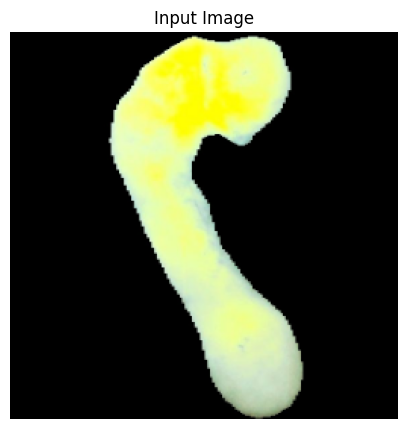

diff (65536, 256) [[16256.25  17436.002 18657.078 ... 18657.078 17436.002 16256.25 ]
 [16256.25  17436.002 18657.078 ... 18657.078 17436.002 16256.25 ]
 [16256.25  17436.002 18657.078 ... 18657.078 17436.002 16256.25 ]
 ...
 [16256.25  17436.002 18657.078 ... 18657.078 17436.002 16256.25 ]
 [16256.25  17436.002 18657.078 ... 18657.078 17436.002 16256.25 ]
 [16256.25  17436.002 18657.078 ... 18657.078 17436.002 16256.25 ]]


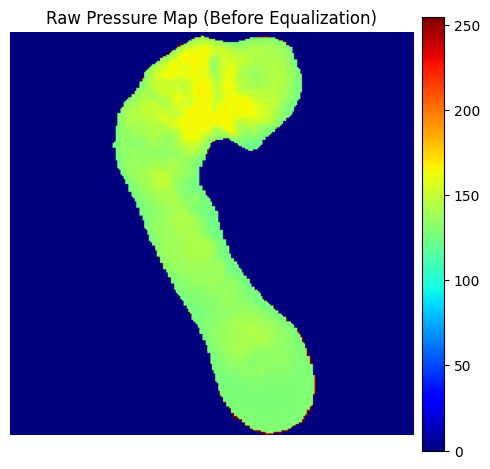

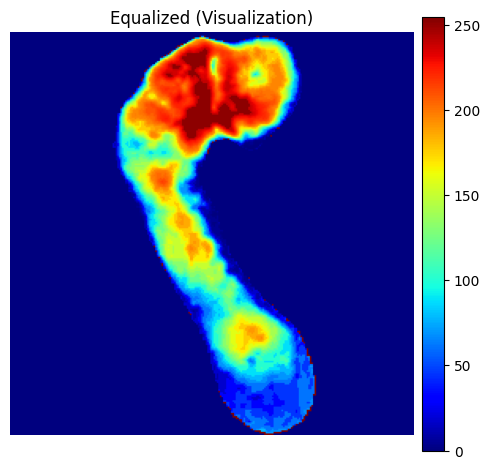

In [17]:
# ============================================
# 사용 예시
# 1) 발바닥 원본 이미지 읽기
# 2) 원본 이미지를 그대로 표시
# 3) Jet 역변환 + 배경 제거로 압력 맵 계산
# 4) Raw / Equalized 히트맵 비교 시각화
# ============================================

# 왼발 이미지를 사용하고 싶다면 아래 라인의 주석을 해제
img_bgr = cv2.imread("test_foot_data/0_Original_Source.png_left_256.png")

# 테스트용으로 오른발 이미지를 사용
# img_bgr = cv2.imread("test_foot_data/0_Original_Source.png_right_256.png")

# OpenCV는 BGR 순서로 이미지를 읽어오기 때문에
# Matplotlib에서 올바르게 표시하기 위해 RGB 순서로 변환
img = img_bgr[:, :, ::-1]

# (1) 입력 원본 이미지 표시
plt.figure(figsize=(5, 10))
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")
plt.show()

# (2) Jet 컬러가 입혀진 이미지 -> 실제 압력 값 맵으로 변환
pm = make_pressure_map(img)

# 변환된 압력 맵을 바로 히트맵으로 확인
plot_heatmap(pm, "Raw Pressure Map (Before Equalization)")

# (3) 압력 값 분포를 보기 좋게 평탄화한 히트맵
pm_eq = equalize_for_visualization(pm)
plot_heatmap(pm_eq, "Equalized (Visualization)")
